Question 1

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


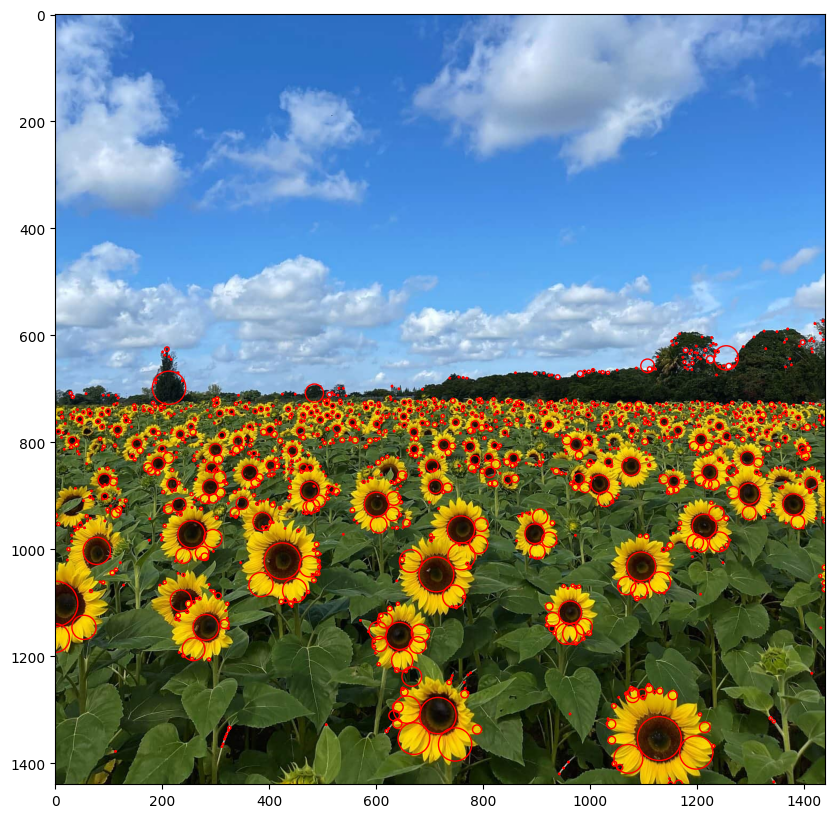

largest circle: center = (0.0, 1102.0), radius = 42.4, sigma = 30.0


In [27]:
from matplotlib.patches import Circle

image = cv.imread('the_berry_farms_sunflower_field.jpeg')
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255

sigma_values = np.linspace(1, 35, num=35) # 35 values from 1 to 35
print(sigma_values)
blobs = []
responses = []  

for sigma in sigma_values:
    ksize = int(2 * np.ceil(3 * sigma) + 1) # kernel size
    X, Y = np.meshgrid(np.arange(-ksize//2 + 1, ksize//2 + 1), np.arange(-ksize//2 + 1, ksize//2 + 1))
    LOG = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (np.pi * sigma**4)  # Normalized LoG
    LOG = LOG * (sigma**2) # Scale normalization
    resp = np.square(cv.filter2D(gray_image, -1, LOG))
    # plt.imshow(log_response, cmap='gray')
    # plt.title(f"Log Response (σ={sigma:.2f})")
    # plt.axis('off')
    # plt.show()
    responses.append(resp)
    
scale_space = np.stack(responses, axis=0)   # shape: (S, H, W)

# 3D Non-Maximum Suppression (NMS) 
S, H, W = scale_space.shape

# 2D local max within each scale (3x3)
# Using dilation as a fast max filter
nhood = np.ones((3, 3), np.uint8)
is_local_max_2d = np.zeros_like(scale_space, dtype=bool)
for s in range(S):
    m = cv.dilate(scale_space[s], nhood)
    is_local_max_2d[s] = (scale_space[s] >= m)

# Compare across scales: current >= prev and >= next
# pad with -inf at ends so first/last scales only compare one side
neg_inf = -np.inf
prev_scale = np.vstack([np.full((1, H, W), neg_inf, dtype=scale_space.dtype), scale_space[:-1]])
next_scale = np.vstack([scale_space[1:], np.full((1, H, W), neg_inf, dtype=scale_space.dtype)])

is_scale_peak = (scale_space >= prev_scale) & (scale_space >= next_scale) #element wise AND

# Combine 2D and scale checks
candidates = is_local_max_2d & is_scale_peak

# Threshold to keep strong peaks (use percentile or fraction of max)
thr = np.percentile(scale_space[candidates], 98) if np.any(candidates) else np.percentile(scale_space, 99)
strong = candidates & (scale_space >= thr)

# Extract coordinates
s_idx, y_idx, x_idx = np.where(strong)
blobs = []
for s, y, x in zip(s_idx, y_idx, x_idx):
    sigma = float(sigma_values[s])
    radius = np.sqrt(2.0) * sigma  # LoG: r = sqrt(2)*sigma (characteristic scale)
    score = float(scale_space[s, y, x])
    blobs.append((y, x, radius, sigma, score))

# sort by score ,descending
blobs.sort(key=lambda t: t[-1], reverse=True)

# suppress duplicates that are too close
def suppress_close(blobs, min_dist=5):
    kept = []
    for b in blobs:
        y, x = b[0], b[1]
        if all((y - y2)**2 + (x - x2)**2 > min_dist**2 for (y2, x2, *_ ) in kept):
            kept.append(b)
    return kept

blobs = suppress_close(blobs, min_dist=5)

def plot_blobs(image, blobs):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    for i, (y, x, r, sigma, score) in enumerate(blobs[:]):
        circ = Circle((x, y), r, color='red', fill=False, linewidth=1)
        ax.add_patch(circ)

    #ax.set_axis_off()
    plt.show()

# Example usage:
plot_blobs(image, blobs)

def largest_circle(blobs):
    max_blob = max(blobs, key=lambda b: b[2])  # b[2] is the radius
    return "largest circle: center = ({:.1f}, {:.1f}), radius = {:.1f}, sigma = {:.1f}".format(max_blob[1], max_blob[0], max_blob[2], max_blob[3])
largest = print(largest_circle(blobs))

Question 2

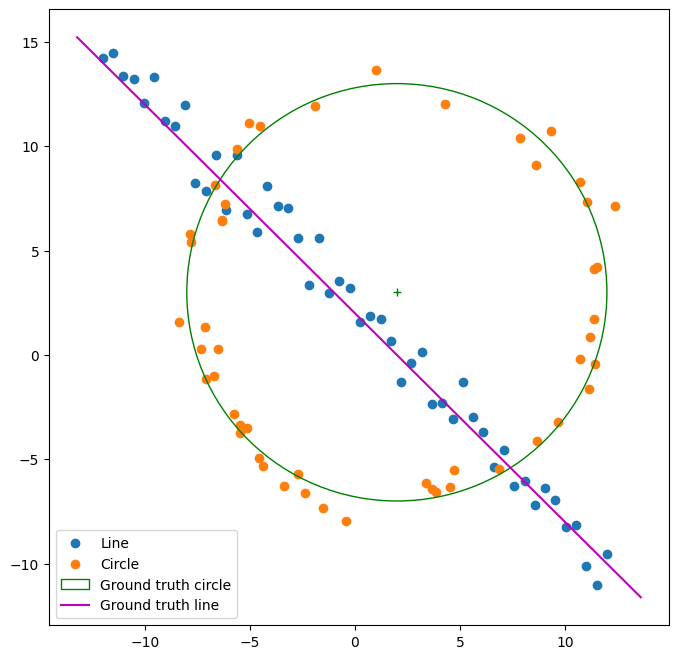

In [66]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
#import tikzplotlib

np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

part (a) Estimate the line using the RNASAC algorithm

Number of iterations N
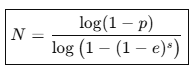     And concidered 70% of the data points should be inliers.

Estimated line: -0.718x + -0.696y = -1.475, with 36 inliers
y = -1.033x + 2.121


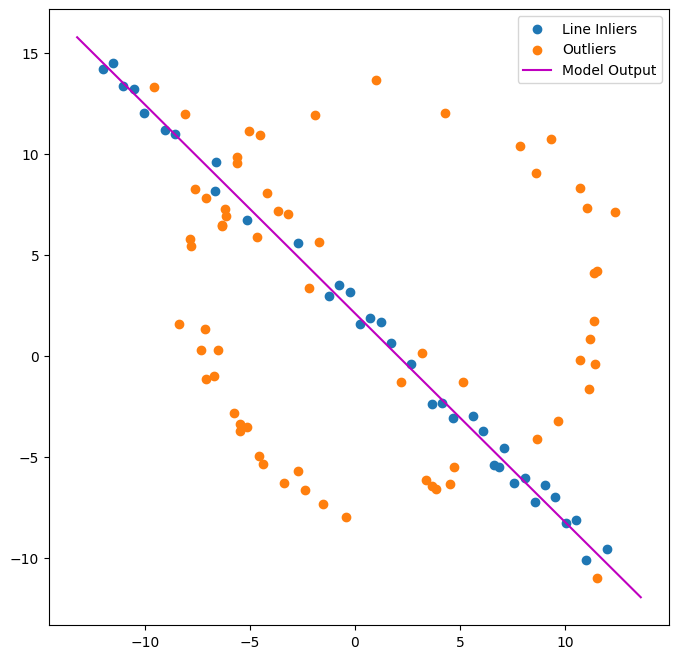

In [67]:
def ransac_line(X, n_iters=1000, threshold=0.6, min_inliers=35):
    best_a, best_b, best_d = 0, 0, 0
    best_inliers = []
    n_points = X.shape[0]
    for _ in range(n_iters):
        idx = np.random.choice(n_points, 2, replace=False)
        
        p1, p2 = X[idx]
        #parameters
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = p1[0]*p2[1] - p2[0]*p1[1]
        #normalizing
        norm = np.sqrt(a**2 + b**2)
        a, b, d = a/norm, b/norm, d/norm
    
        distances = calc_tls_line(a, b, d, X)
        
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers = inliers
            best_a, best_b, best_d = a, b, d
            choosen_points_line = [p1, p2]
        
    return best_a, best_b, best_d, best_inliers, choosen_points_line

def calc_tls_line(a,b,d,X):
    distances = np.abs(a*X[:,0] + b*X[:,1] - d) 
    return distances

#plot results
a, b, d, line_inliers, choosen_points_line = ransac_line(X)
print(f"Estimated line: {a:.3f}x + {b:.3f}y = {d:.3f}, with {len(line_inliers)} inliers")
print(f"y = {-a/b:.3f}x + {d/b:.3f}")

line_inliers = X[line_inliers]
line_outliers = np.array([e for e in X if e not in line_inliers])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# Plot the original points
ax.scatter(line_inliers[:,0], line_inliers[:,1], label='Line Inliers')
ax.scatter(line_outliers[:,0], line_outliers[:,1], label='Outliers')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
m = -a/b
c = d/b
y_ = m*x_ + c
plt.plot(x_, y_, color='m', label='Model Output')
plt.legend()

part (b) Estimate the circle that fits the remnant using RANSAC

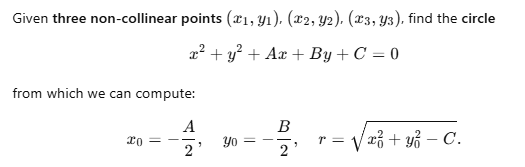
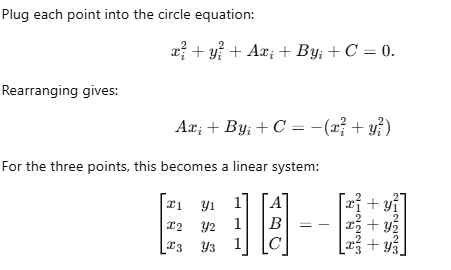

Estimated circle: center = (1.933, 2.999), radius = 9.913, with 52 inliers


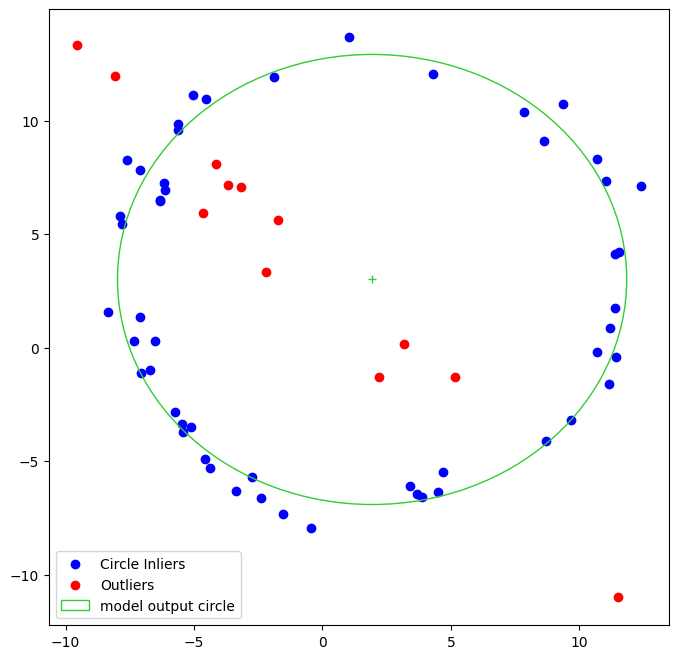

In [68]:
def distance_error_circle(params, X):
    x0, y0, r = params
    distances = np.abs(np.sqrt((X[:,0]-x0)**2 + (X[:,1]-y0)**2) - r)
    return distances

def ransac_circle(X, n_iters=1000, threshold=1.5, min_inliers=45):
    best_params = [0, 0, 0]
    best_inliers = []
    n_points = X.shape[0]
    for _ in range(n_iters):
        idx = np.random.choice(n_points, 3, replace=False)
        p1, p2, p3 = X[idx]
        
        A = np.array([[p1[0], p1[1], 1],
                      [p2[0], p2[1], 1],
                      [p3[0], p3[1], 1]])
        B = np.array([[-(p1[0]**2 + p1[1]**2)],
                      [-(p2[0]**2 + p2[1]**2)],
                      [-(p3[0]**2 + p3[1]**2)]])
        try :
            C = linalg.solve(A, B)
        except linalg.LinAlgError:
            continue
        C = C.flatten()
        x0, y0 = -C[0]/2, -C[1]/2
        r = np.sqrt((C[0]**2 + C[1]**2)/4 - C[2])

        distances = distance_error_circle((x0, y0, r), X)
        
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers = inliers
            best_params = [x0, y0, r]
            choosen_points_circle = [p1, p2, p3]

    return best_params, best_inliers, choosen_points_circle

params, circle_inliers, choosen_points_circle = ransac_circle(line_outliers)
circle_inliers = line_outliers[circle_inliers]
#least squares circle fit on those inliers for the final refined circle.
def refine_circle(inliers):
    x, y = inliers[:,0], inliers[:,1]
    A = np.column_stack((x, y, np.ones_like(x)))
    b = -(x**2 + y**2)
    C, *_ = np.linalg.lstsq(A, b, rcond=None)
    A_, B_, C_ = C
    x0, y0 = -0.5*A_, -0.5*B_
    r = np.sqrt(x0**2 + y0**2 - C_)
    return x0, y0, r

x0, y0, r = refine_circle(circle_inliers)
print(f"Estimated circle: center = ({x0:.3f}, {y0:.3f}), radius = {r:.3f}, with {len(circle_inliers)} inliers")

circle_outliers = np.array([e for e in line_outliers if e not in circle_inliers])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# Plot the original points
ax.scatter(circle_inliers[:,0], circle_inliers[:,1], label='Circle Inliers', color = 'blue')
ax.scatter(circle_outliers[:,0], circle_outliers[:,1], label='Outliers', color = 'red')
x_min, x_max = ax.get_xlim()
circle = plt.Circle((x0,y0), r, color='limegreen', fill=False, label='model output circle')
ax.plot((x0), (y0), '+', color='limegreen')
ax.add_patch(circle)
plt.legend()


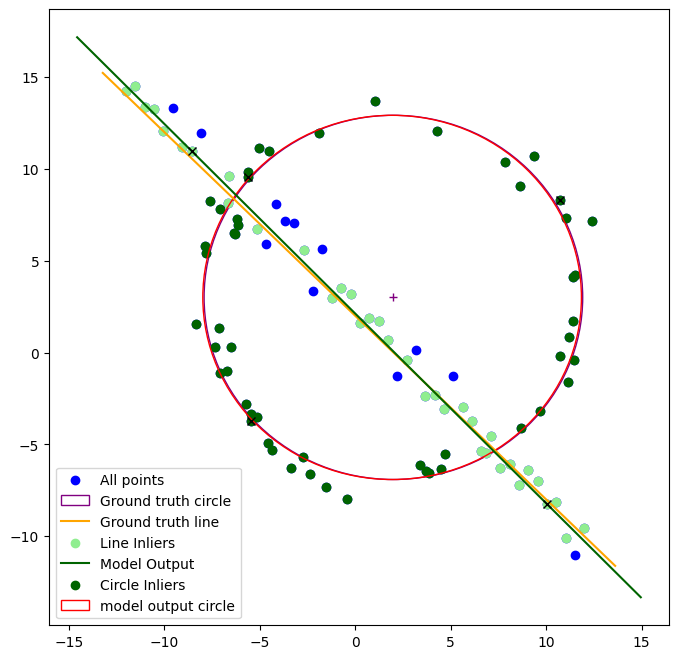

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

#all points
ax.scatter(X[:, 0], X[:, 1], label='All points', color ='blue')

#ground truth
# ax.scatter(X_line[:, 0], X_line[:, 1], label='gt_Line', color='orange')
# ax.scatter(X_circ[:, 0], X_circ[:, 1], label='gt_Circle', color='purple')
circle_gt = plt.Circle((x0_gt, y0_gt), r, fill=False, label='Ground truth circle', color='purple')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='purple')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = -1*x_ + 2
plt.plot(x_, y_, label='Ground truth line', color='orange')

#line 
ax.scatter(line_inliers[:,0], line_inliers[:,1], label='Line Inliers', color='lightgreen')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
m = -a/b
c = d/b
y_ = m*x_ + c
plt.plot(x_, y_, label='Model Output', color='darkgreen')
ax.plot(choosen_points_line[0][0], choosen_points_line[0][1], 'x', color='black')
ax.plot(choosen_points_line[1][0], choosen_points_line[1][1], 'x', color='black')

#circle 
ax.scatter(circle_inliers[:,0], circle_inliers[:,1], label='Circle Inliers', color = 'darkgreen')
x_min, x_max = ax.get_xlim()
circle = plt.Circle((x0,y0), r, color='red', fill=False, label='model output circle')
ax.add_patch(circle)
ax.plot(choosen_points_circle[0][0], choosen_points_circle[0][1], 'x', color='black')
ax.plot(choosen_points_circle[1][0], choosen_points_circle[1][1], 'x', color='black')
ax.plot(choosen_points_circle[2][0], choosen_points_circle[2][1], 'x', color='black')

plt.legend()

part (d)
If the circle is fitted first, RANSAC is likely to fail or give inaccurate results. Many random 3-point samples will come from the line portion of the data, which are nearly collinear and lead to unstable or extremely large-radius circles that incorrectly cover both the line and circle points. This causes RANSAC to select a false circle model with a large consensus, removing many true circle points as outliers. As a result, the remaining points will not form a clean line set, and the later line fitting step will perform poorly. Therefore, it is better to fit the line first and then the circle, since the line’s smaller minimal sample (2 points) and well-defined perpendicular error metric make it more stable and easier to separate before estimating the circle.

Question 3

In [ ]:
import cv2
import numpy as np

background = cv2.imread('building.jpg')   # architectural image
overlay = cv2.imread('flag.png')          # flag image

# Resize overlay to a manageable size
overlay = cv2.resize(overlay, (300, 200))

points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print(f"Point selected: {x}, {y}")

img_copy = background.copy()
cv2.imshow('Select 4 points', img_copy)
cv2.setMouseCallback('Select 4 points', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Points:", points)

dst_pts = np.array(points, dtype=np.float32)


# source points (corners of the flag)
h, w = overlay.shape[:2]
src_pts = np.array([
    [0, 0],
    [w - 1, 0],
    [w - 1, h - 1],
    [0, h - 1]
], dtype=np.float32)

# Compute Homography and warp the overlay image
H, _ = cv2.findHomography(src_pts, dst_pts)
warped_flag = cv2.warpPerspective(overlay, H, (background.shape[1], background.shape[0]))

# Binary mask of the quad
mask = np.zeros(background.shape[:2], dtype=np.uint8)
cv2.fillConvexPoly(mask, dst_pts.astype(int), 255)

# Convert to float for proper blending
bg_f   = background.astype(np.float32)
flag_f = warped_flag.astype(np.float32)
alp    = 0.5  # 0=transparent, 1=opaque

# Build per-pixel alpha in [0,1] but only inside the quad
a = (mask.astype(np.float32) / 255.0) * alp

# Broadcast alpha to 3 channels
a3 = cv2.merge([a, a, a])

# Blend INSIDE the mask with original background pixels
result_f = bg_f * (1.0 - a3) + flag_f * a3

# Keep background outside the mask exactly unchanged
result = result_f.astype(np.uint8)

cv2.imshow('Transparent Flag Overlay', result)
cv2.imwrite('overlay_transparent_result.jpg', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

Point selected: 498, 449
Point selected: 710, 460
Point selected: 566, 581
Point selected: 339, 567
Points: [(498, 449), (710, 460), (566, 581), (339, 567)]


Question 4

SIFT: 2862 vs 3960 keypoints; good matches after ratio test: 109


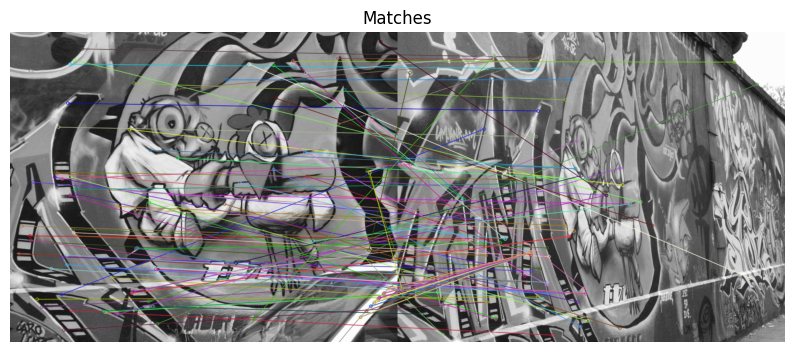

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

imgA = cv2.imread('graf/graf/img1.ppm')  # source (to be warped)
imgB = cv2.imread('graf/graf/img5.ppm')  # destination (canvas)
assert imgA is not None and imgB is not None, "Could not load img1.ppm / img5.ppm"

# SIFT keypoints and descriptors
sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1)
kpsA, desA = sift.detectAndCompute(imgA, None)
kpsB, desB = sift.detectAndCompute(imgB, None)

# Lowe ratio test matcher (kNN=2)
bf = cv2.BFMatcher()
knn = bf.knnMatch(desA, desB, k=2)

ratio = 0.75   # Lowe's ratio ~0.75–0.8
good = []
for m, n in knn:
    if m.distance < ratio * n.distance:
        good.append(m)

print(f"SIFT: {len(kpsA)} vs {len(kpsB)} keypoints; good matches after ratio test: {len(good)}")

plt.figure(figsize=(10, 10))
#Optional: draw matches (sanity check)
vis = cv2.drawMatches(cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY), kpsA, cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY), kpsB, good, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.title("Matches")
plt.axis('off')
plt.show()


In [ ]:

def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)
        #print(f'Iteration {i}: No. of inliers = {len(inliers)}')

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

np.random.seed(62)
pad = 100

final_transform = transform.ProjectiveTransform(np.identity(3))
final_transformed_image = transform.warp(imgA, final_transform.inverse)

good_matches, keypoints1, keypoints5 = good, kpsA, kpsB
tform, _ = find_best_homography(good_matches, keypoints1, keypoints5)

final_transformed_image = transform.warp(final_transformed_image, tform.inverse)
final_transform = final_transform + tform

plt.figure(figsize = (6, 6))
plt.imshow(final_transformed_image)
plt.title(f"Homography")
plt.axis('off')
plt.tight_layout()

final_transformed_image = transform.warp(imgA, final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * imgB + final_transformed_image

plt.figure(figsize = (10, 10))
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()